## Домашнее задание

### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data.drop(columns = ['year','month','dayofmonth','quarter','dayofyear','weekofyear','dayofweek','hour','is_holiday','is_prev_holiday','is_next_holiday'], inplace = True)

C:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


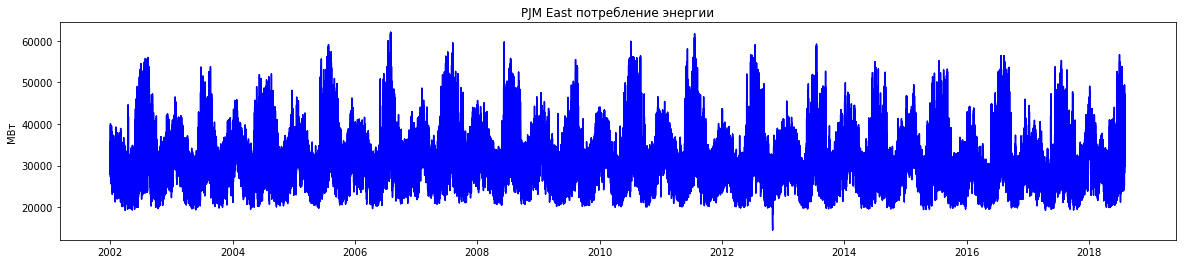

In [4]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [5]:
data_m = data.resample('M').mean()

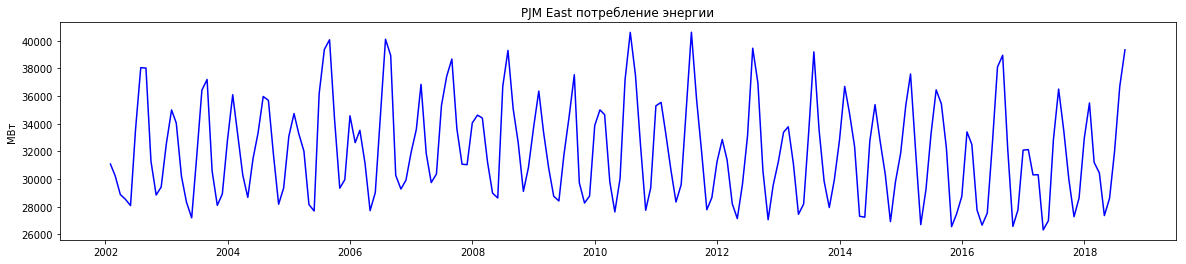

In [6]:
plt.figure(figsize =(20,4))
plt.plot( data_m.index, data_m['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

### 2. Подберите параметры модели SARIMAX для этого ряда.

In [7]:
from scipy import stats
import statsmodels.api as sm

Явно выраженная полугодовая сезонность + тренд

Проверка стационарности и STL-декомпозиция ряда

Критерии Дики-Фуллера 0.30756991209997214


<Figure size 1080x720 with 0 Axes>

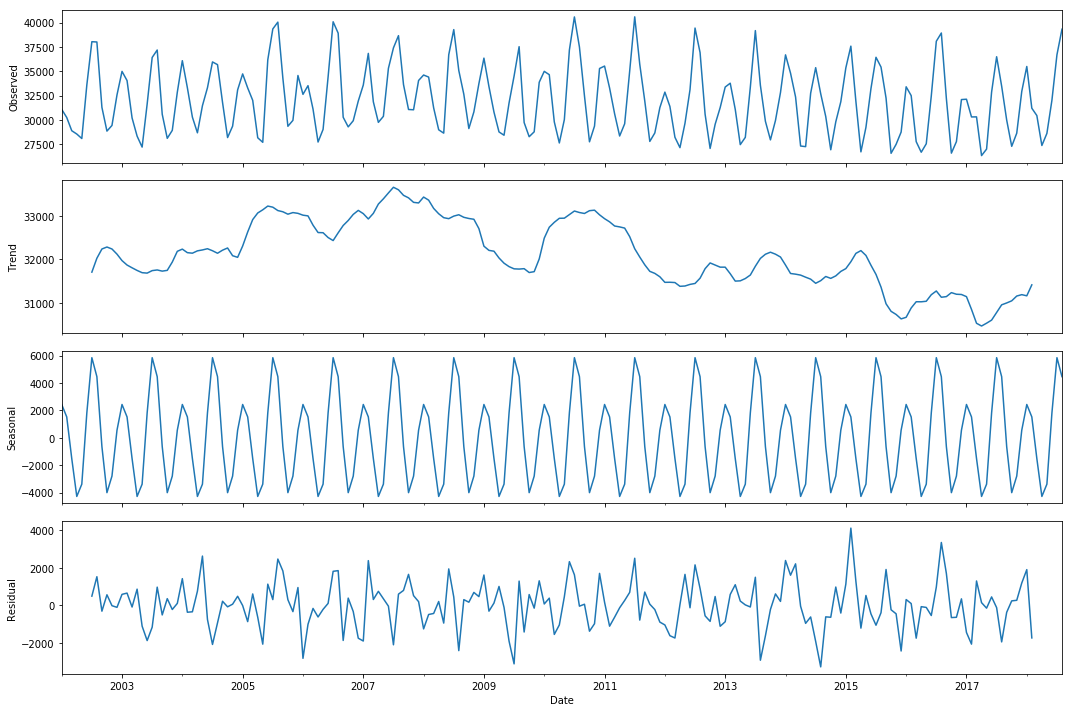

In [8]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data_m.PJME_MW).plot()
print(f'Критерии Дики-Фуллера {sm.tsa.stattools.adfuller(data_m.PJME_MW)[1]}')

Гипотеза нестационарности для этого ряда не отвергается

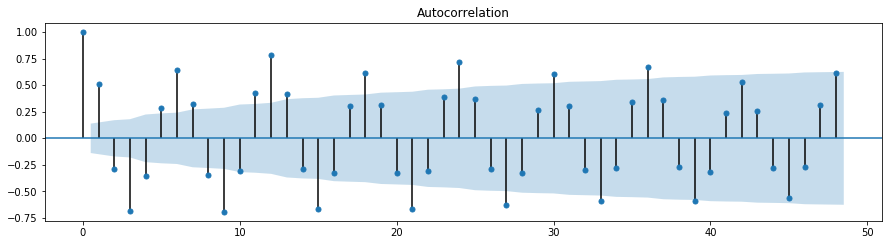

In [9]:
plt.figure(figsize(15, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_m.PJME_MW.values.squeeze(), lags=48, ax=ax)
pylab.show()

Явно видна полугодовая сезонность

Попробуем сезонное дифференцирование: сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


Критерий Дики-Фуллера 5.431826585656118e-07


<Figure size 1080x720 with 0 Axes>

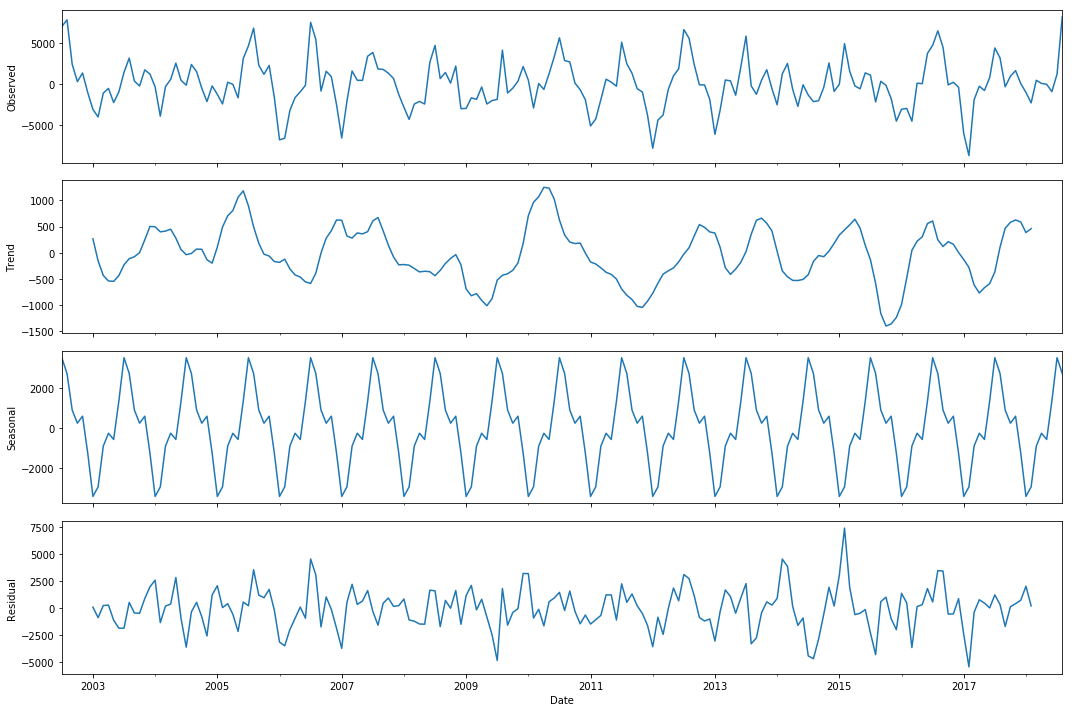

In [10]:
data_m.PJME_MW_D = data_m.PJME_MW - data_m.PJME_MW.shift(6)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data_m.PJME_MW_D[6:]).plot()
print(f'Критерий Дики-Фуллера {sm.tsa.stattools.adfuller(data_m.PJME_MW_D[6:])[1]}')

Гипотеза нестационарности для этого ряда отвергается критерием Дики-Фуллера, следовательно D = 1

### Подбор модели

Посмотрим на ACF и PACF полученного ряда

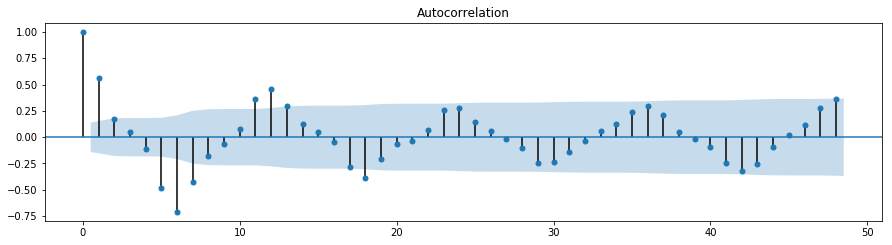

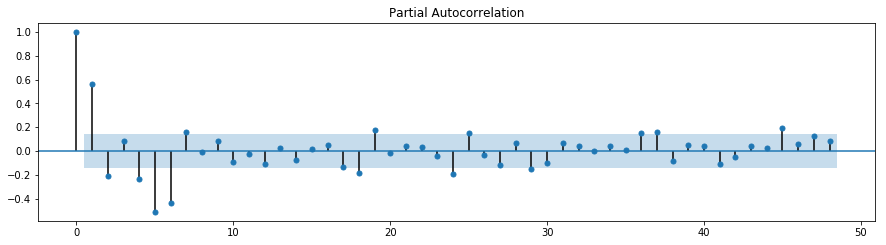

In [11]:
plt.figure(figsize(15, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_m.PJME_MW_D.values[6:].squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_m.PJME_MW_D.values[6:].squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: (Q=3, q=1) - 1-й график, (P=1, p=2) - 2-й график

In [12]:
ps = range(0, 3)
d = 0
qs = range(0, 2)

Ps = range(0, 2)
D = 1
Qs = range(0, 4)

In [13]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [14]:
results = []

In [15]:
#%%time

best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(data_m.PJME_MW, order=(param[0], d, param[1]),
                                         seasonal_order = (param[2], D, param[3], 6)).fit()#disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print(f'wrong parameters {param}')
        continue
    aic = model.aic
    #Сохраняем лучшую модель, AIC, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

In [16]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=[True]).head())

      parameters          aic
41  (2, 1, 0, 1)  3485.582956
45  (2, 1, 1, 1)  3486.323941
42  (2, 1, 0, 2)  3486.424843
43  (2, 1, 0, 3)  3490.089558
29  (1, 1, 1, 1)  3491.117796


### Лучшая модель

In [17]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                           PJME_MW   No. Observations:                  200
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 6)   Log Likelihood               -1737.791
Date:                           Fri, 17 Apr 2020   AIC                           3485.583
Time:                                   12:24:32   BIC                           3501.922
Sample:                               01-31-2002   HQIC                          3492.199
                                    - 08-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2753      0.084     15.112      0.000       1.110       1.441
ar.L2         -0.2763      0.084     -3.300

### Её остатки

Критерий Стьюдента: p = 0.7382463656697202
Критерий Дики-Фуллера 3.0226142642776783e-06


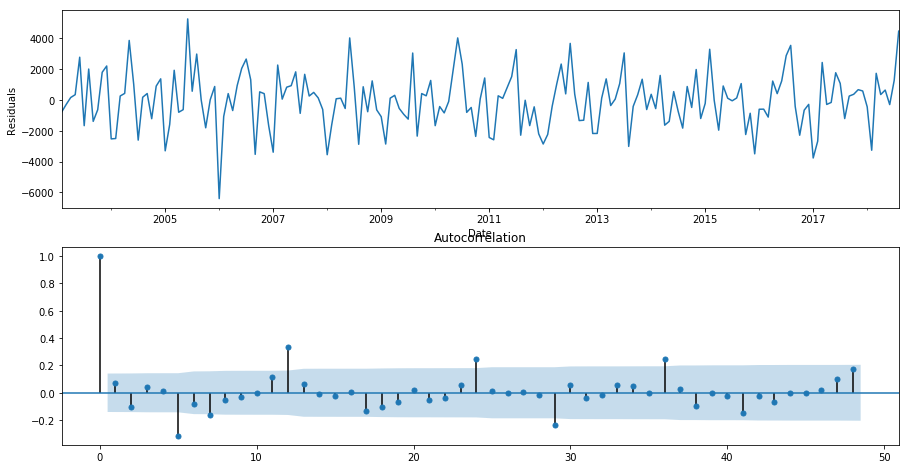

In [18]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[6:].values.squeeze(), lags=48, ax=ax)
print(f'Критерий Стьюдента: p = {stats.ttest_1samp(best_model.resid[6:], 0)[1]}')
print(f'Критерий Дики-Фуллера {sm.tsa.stattools.adfuller(best_model.resid[6:])[1]}')

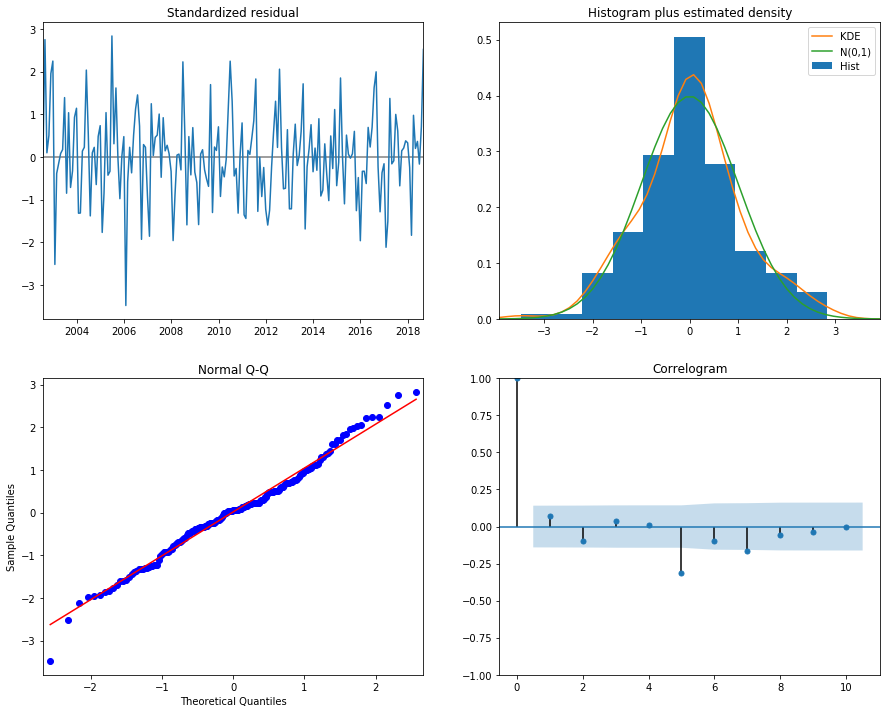

In [19]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Если d = 0, остатки несмещены, близки к нормальному распределению, по присутствует сезонная автокорреляция. При d = 1 автокорреляция остатков исчезает, но остатки смещены и менее близки к нормальному распределению

### Проверка модели

Обучим модель на лучших параметрах и не на всех данных (последние 12 месяцев оставим для теста)

In [20]:
#для построения модели используем все данные, кроме 12-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m.PJME_MW.values[:-12],order=[2,0,1],
                                seasonal_order=[0,1,1,6] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 3096.6638034985504


Сделаем предсказания на 24 месяца вперед и сравним с фактом первые 12 месяцев предсказаний

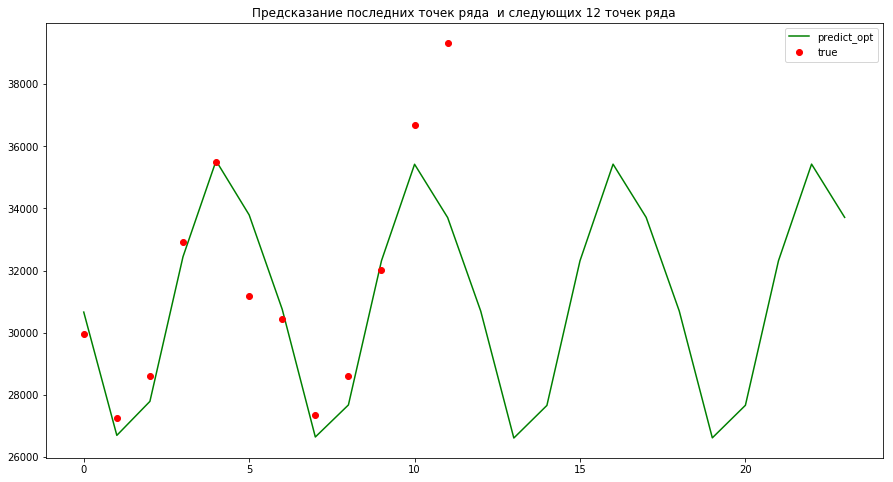

In [21]:
pred_dynamic_opt = results_opt.forecast(24)
plt.plot(pred_dynamic_opt,'g', label='predict_opt')
#Отобразим истинный значения 
plt.plot(data_m.PJME_MW.values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()

plt.show()

### 3. Сделайте вывод о том, как изменилась модель по сравнению с недельной

Модель по сравнению с недельной более точно проходит точки, если сравнивать предсказания на 3 месяца в этой модели и предсказания на 12 недель в недельной модели

### 4. Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)


In [51]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [52]:
brent_data.drop(columns = ['year','month','dayofmonth','quarter','dayofyear','weekofyear','dayofweek','is_holiday','is_prev_holiday','is_next_holiday'], inplace = True)

In [53]:
brent_data_w = brent_data.resample('W').mean()

In [54]:
brent_data_w.head()

,Значение
Дата,
2010-09-05,76.616000
2010-09-12,77.673333
2010-09-19,78.693333
2010-09-26,78.518333
2010-10-03,81.211667


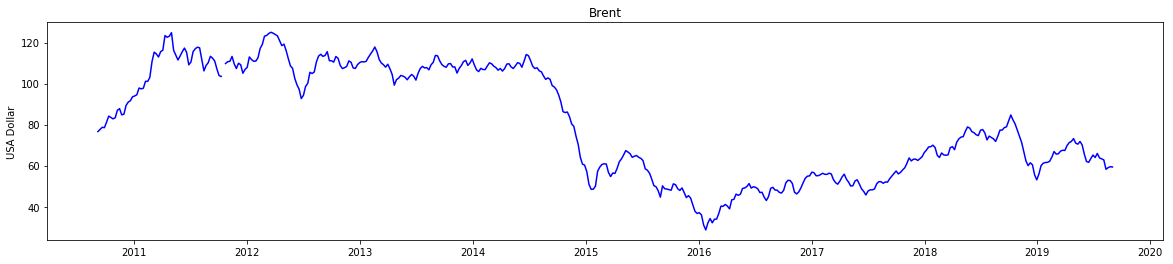

In [55]:
plt.figure(figsize = (20,4))
plt.plot( brent_data_w.index, brent_data_w['Значение'], 'b' )
plt.title('Brent' )
plt.ylabel ('USA Dollar')
plt.show()

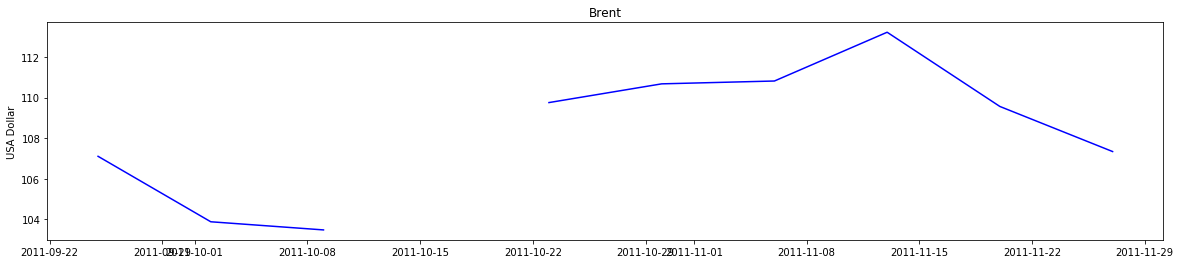

In [56]:
plt.figure(figsize = (20,4))
plt.plot( brent_data_w.index[55:65], brent_data_w['Значение'][55:65], 'b')
plt.title('Brent' )
plt.ylabel ( 'USA Dollar' )
plt.show()

Обнаружен пропуск в данных 

In [57]:
brent_data_w.index[55:65]

DatetimeIndex(['2011-09-25', '2011-10-02', '2011-10-09', '2011-10-16',
               '2011-10-23', '2011-10-30', '2011-11-06', '2011-11-13',
               '2011-11-20', '2011-11-27'],
              dtype='datetime64[ns]', name='Дата', freq='W-SUN')

In [58]:
brent_data_w['Значение'][55:65]

Дата
2011-09-25    107.106667
2011-10-02    103.878333
2011-10-09    103.476667
2011-10-16           NaN
2011-10-23    109.756667
2011-10-30    110.680000
2011-11-06    110.820000
2011-11-13    113.225000
2011-11-20    109.565000
2011-11-27    107.341667
Freq: W-SUN, Name: Значение, dtype: float64

In [59]:
brent_data_w.loc['2011-10-16'] = (brent_data_w.loc['2011-10-9'] + brent_data_w.loc['2011-10-23'])/2

In [60]:
brent_data_w['Значение'][55:65]

Дата
2011-09-25    107.106667
2011-10-02    103.878333
2011-10-09    103.476667
2011-10-16    106.616667
2011-10-23    109.756667
2011-10-30    110.680000
2011-11-06    110.820000
2011-11-13    113.225000
2011-11-20    109.565000
2011-11-27    107.341667
Freq: W-SUN, Name: Значение, dtype: float64

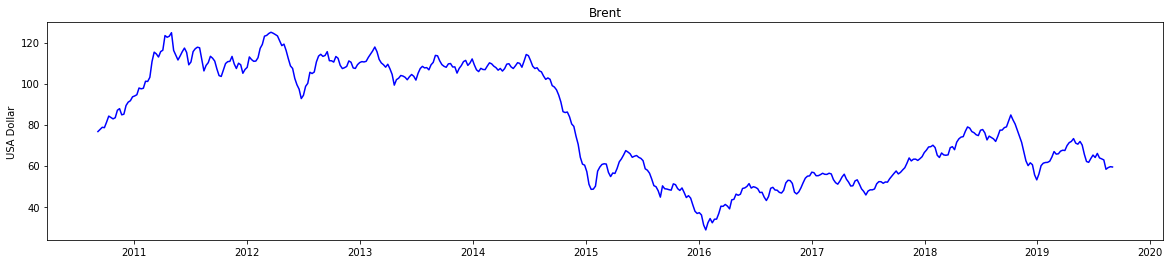

In [61]:
plt.figure(figsize =(20,4))
plt.plot( brent_data_w.index, brent_data_w['Значение'], 'b' )
plt.title('Brent')
plt.ylabel ('USA Dollar')
plt.show()

Проверка стационарности и STL-декомпозиция ряда

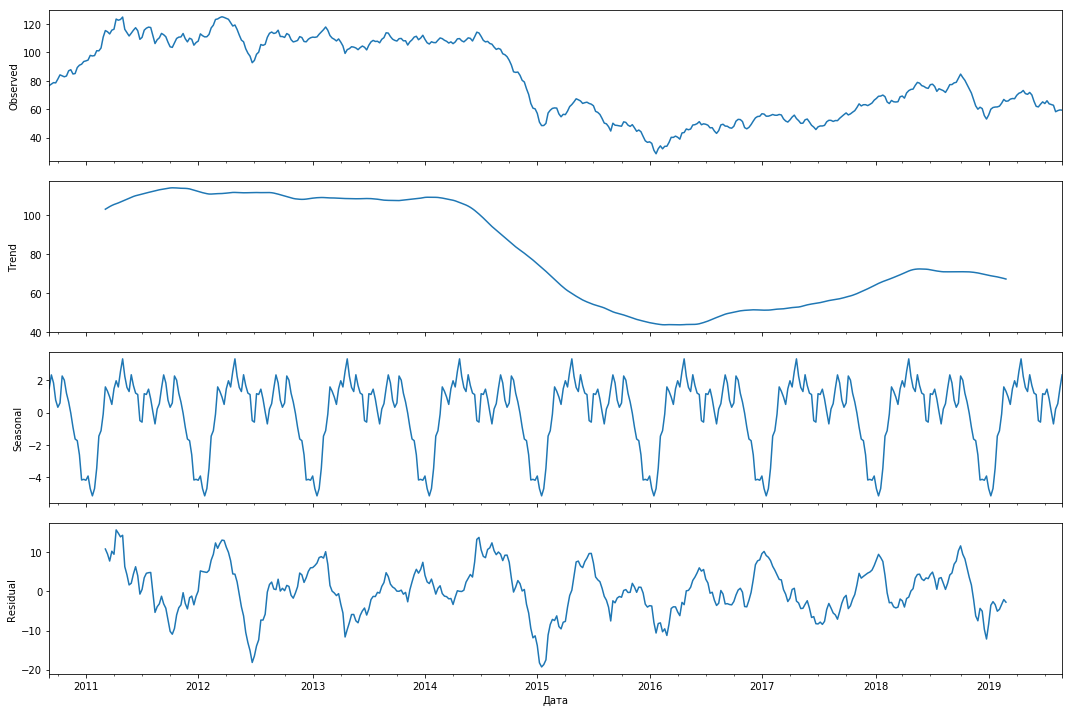

<Figure size 1080x720 with 0 Axes>

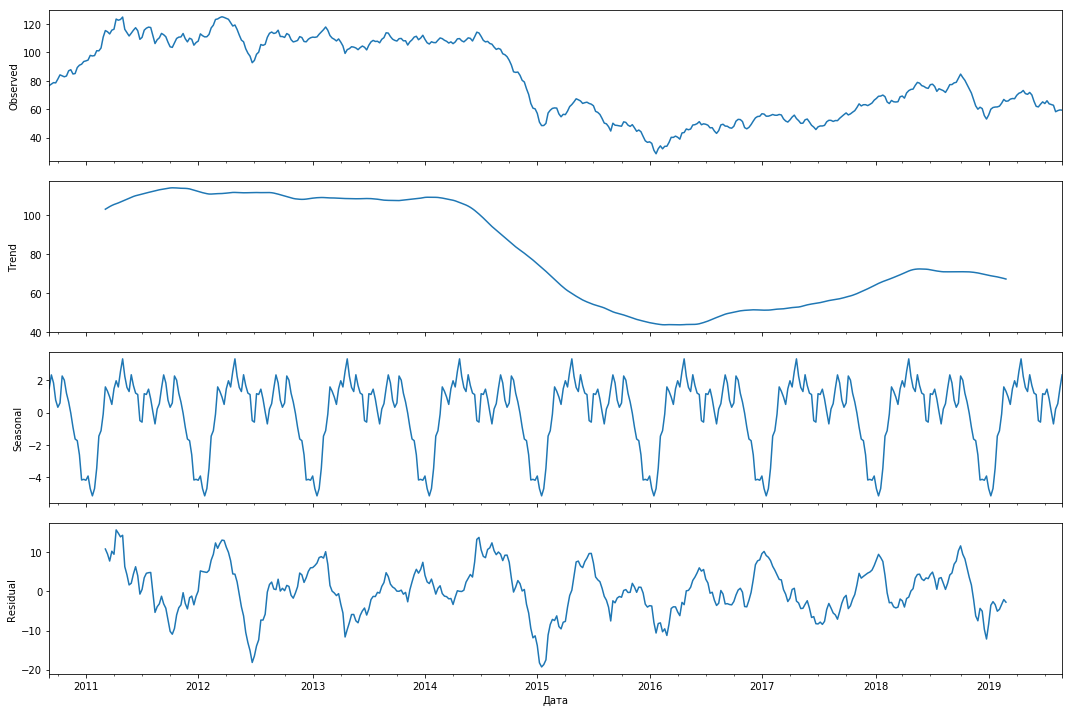

In [79]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(brent_data_w["Значение"]).plot()

In [78]:
print(f'Критерии Дики-Фуллера {sm.tsa.stattools.adfuller(brent_data_w["Значение"])[1]}')

Критерии Дики-Фуллера 0.6395940238003527


Гипотеза нестационарности для этого ряда не отвергается

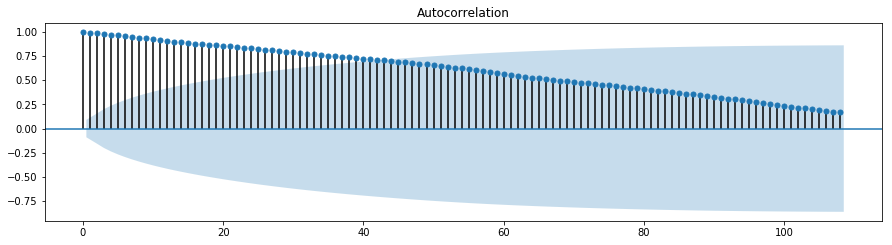

In [84]:
plt.figure(figsize(15, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(brent_data_w['Значение'].values.squeeze(), lags=108, ax=ax)
pylab.show()

Сезонной автокорреляции нет

### Стационарность

Критерий Дики-Фулера не отвергает гипотезу нестационарности. Сезонной автокорреляции нет, поэтому попробуем обычное дифференцирование:

Критерий Дики-Фуллера 7.217491478021306e-12


<Figure size 1080x720 with 0 Axes>

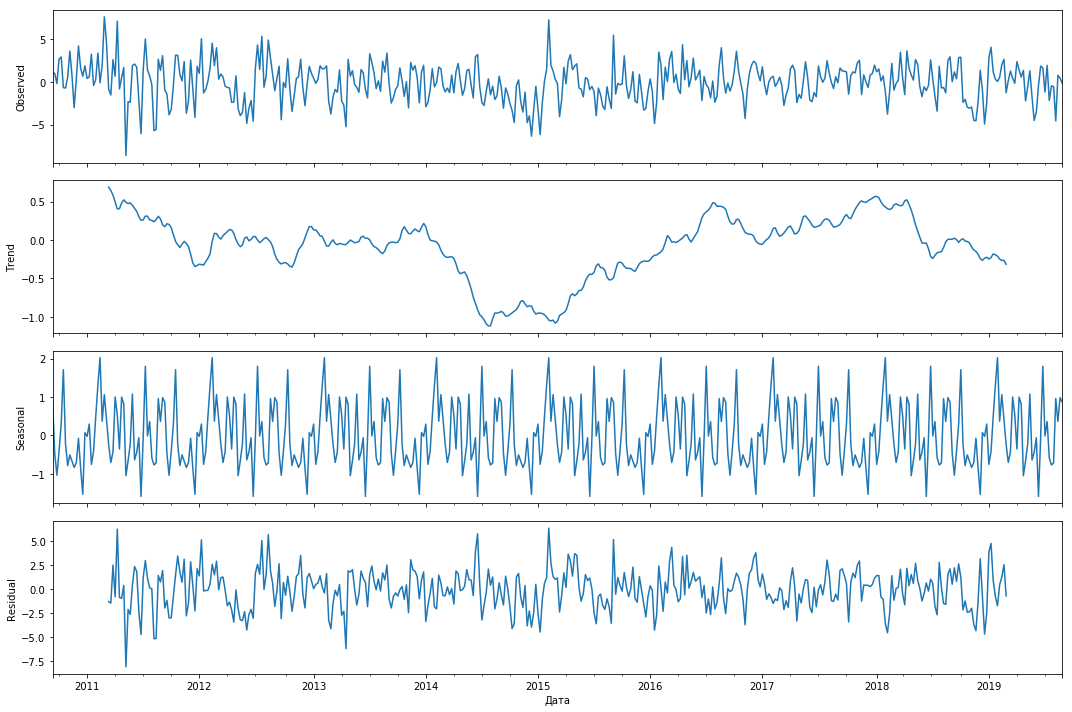

In [91]:
brent_data_w['value_d'] = brent_data_w["Значение"] - brent_data_w["Значение"].shift(1)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(brent_data_w.value_d[1:]).plot()
print(f'Критерий Дики-Фуллера {sm.tsa.stattools.adfuller(brent_data_w.value_d[2:])[1]}')

Гипотеза нестационарности отвергается

### Подбор модели

Посмотрим на ACF и PACF полученного ряда

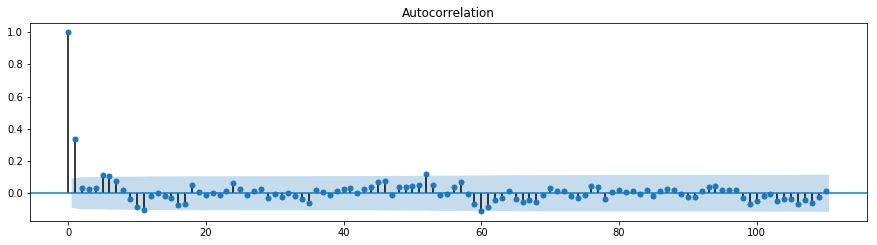

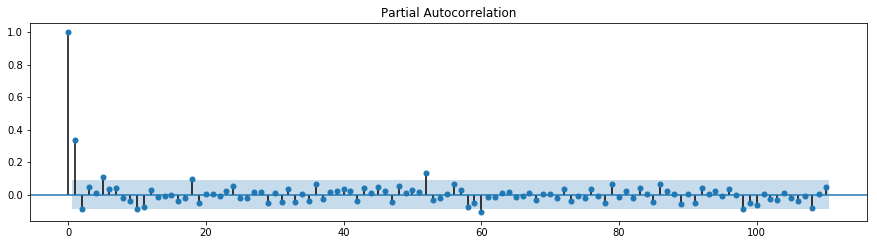

In [96]:
plt.figure(figsize(15, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(brent_data_w.value_d[1:].values.squeeze(), lags=110, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(brent_data_w.value_d[1:].values.squeeze(), lags=110, ax=ax)
pylab.show()

Начальные приближения: (Q=1, q=1) - 1-й график, (P=1, p=2) - 2-й график

In [97]:
ps = range(0, 3)
d = 1
qs = range(0, 2)

Ps = range(0, 2)
D = 0
Qs = range(0, 2)

In [98]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

Перебираем все возможные комбинации параметров

In [99]:
results = []

In [101]:
#%%time

best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(brent_data_w['Значение'], order=(param[0], d, param[1]),
                                         seasonal_order = (param[2], D, param[3], 52)).fit()#disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print(f'wrong parameters {param}')
        continue
    aic = model.aic
    #Сохраняем лучшую модель, AIC, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

In [102]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=[True]).head())

      parameters          aic
5   (0, 1, 0, 1)  2026.905446
6   (0, 1, 1, 0)  2027.310555
13  (1, 1, 0, 1)  2028.851890
7   (0, 1, 1, 1)  2028.871206
14  (1, 1, 1, 0)  2029.238310


### Лучшая модель

In [103]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           Значение   No. Observations:                  470
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 52)   Log Likelihood               -1010.453
Date:                            Fri, 17 Apr 2020   AIC                           2026.905
Time:                                    13:53:37   BIC                           2039.357
Sample:                                09-05-2010   HQIC                          2031.805
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3619      0.043      8.443      0.000       0.278       0.446
ma.S.L52       0.1524      0.053   

### Её остатки

Критерий Стьюдента: p = 0.7728002516074846
Критерий Дики-Фуллера 0.0


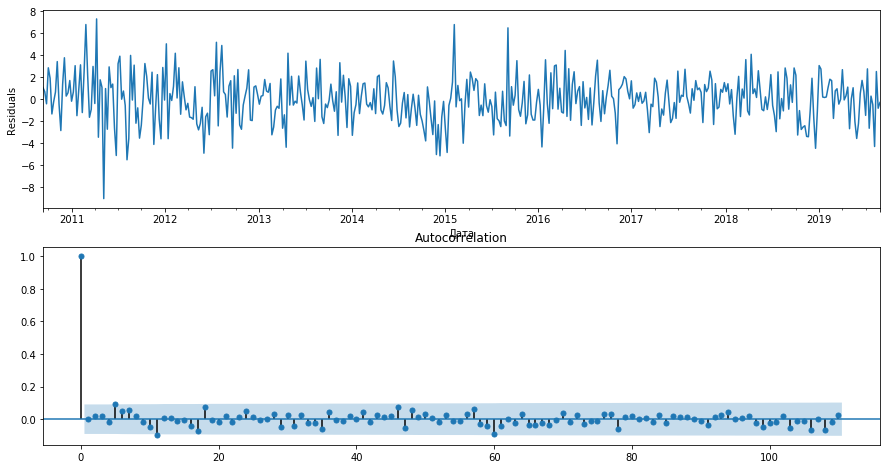

In [108]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[1:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=110, ax=ax)
print(f'Критерий Стьюдента: p = {stats.ttest_1samp(best_model.resid[1:], 0)[1]}')
print(f'Критерий Дики-Фуллера {sm.tsa.stattools.adfuller(best_model.resid[1:])[1]}')

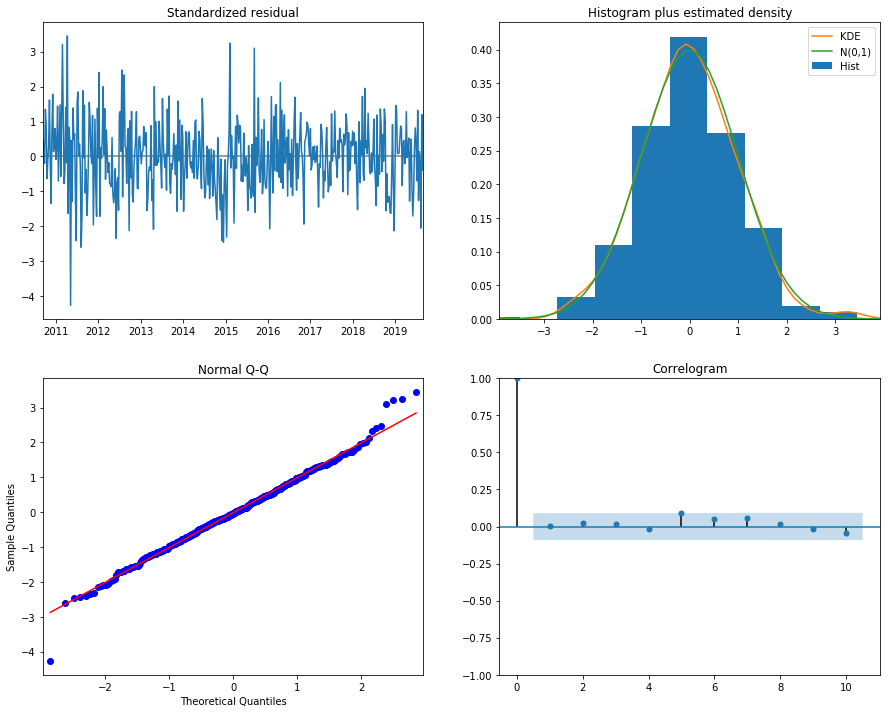

In [109]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (коррелограммой). Посмотрим, насколько хорошо модель описывает данные.

### Проверка модели

In [119]:
#для построения модели используем все данные, кроме 12-х последних недель (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(brent_data_w["Значение"].values[:-100],order=[0,1,1],
                                seasonal_order=[0,0,1,52] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 1337.4487155031898


Сделаем предсказания на 24 месяца вперед и сравним с фактом первые 12 месяцев предсказаний

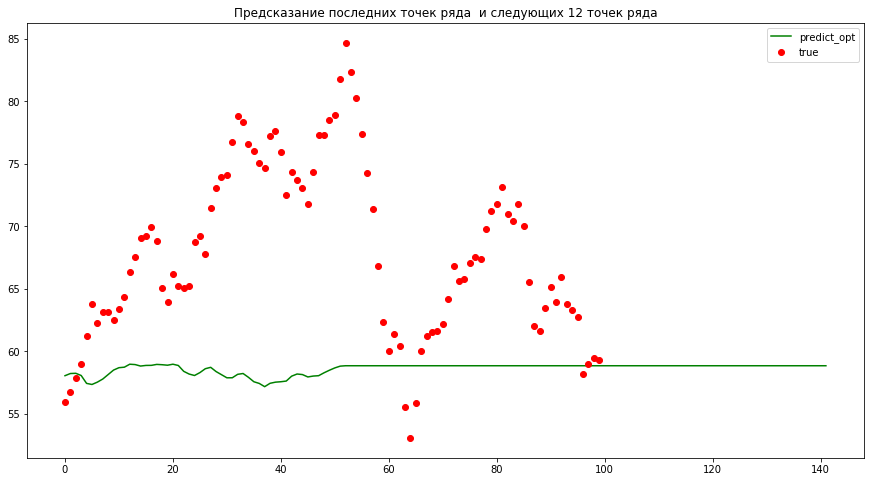

In [120]:
pred_dynamic_opt = results_opt.forecast(142)
plt.plot(pred_dynamic_opt,'g', label='predict_opt')
#Отобразим истинный значения 
plt.plot(brent_data_w["Значение"].values[-100:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()

plt.show()

### 5. Оцените результат моделирования

Результат моделирования такой же неудовлетворительный как и при моделировании без ресемплинга

### 6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.

ARIMA плохо работает с рядами со сложной сезонностью и рядами, поведение признака в которых зависит от случайных событий